In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
test = pd.read_csv('ds4-which-whisk/test.csv')
train = pd.read_csv('ds4-which-whisk/train.csv')

In [3]:
train = train.dropna()

In [4]:
from sklearn.model_selection import train_test_split
train_two, val = train_test_split(train, test_size=0.33, random_state=42)
print('Training Data Shape:', train_two.shape)
print('Testing Data Shape:', val.shape)

Training Data Shape: (1658, 7)
Testing Data Shape: (818, 7)


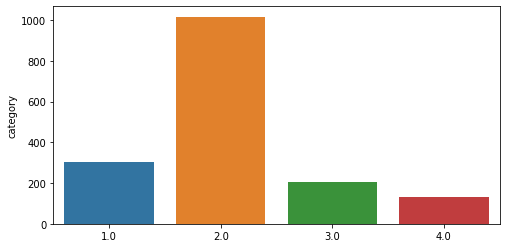

In [5]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = train_two['category'].unique(), y=train_two['category'].value_counts())
plt.show()

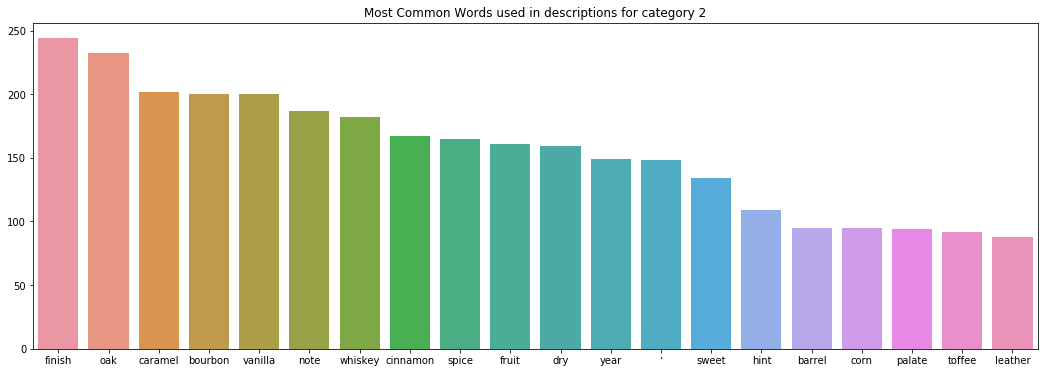

In [6]:
import spacy
import string
from collections import Counter
nlp = spacy.load('en_core_web_lg')
punctuations = string.punctuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if ((tok.is_stop == False) and (tok.is_punct == False)) and (tok.pos_!= 'PRON')]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)
two_text = [text for text in train_two[train_two['category'] == 2]['description']]
one_text = [text for text in train_two[train_two['category'] == 1]['description']]
two_clean = cleanup_text(two_text)
two_clean = ' '.join(two_clean).split()
one_clean = cleanup_text(one_text)
one_clean = ' '.join(one_clean).split()
two_counts = Counter(two_clean)
one_counts = Counter(one_clean)
two_common_words = [word[0] for word in two_counts.most_common(20)]
two_common_counts = [word[1] for word in two_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=two_common_words, y=two_common_counts)
plt.title('Most Common Words used in descriptions for category 2')
plt.show()

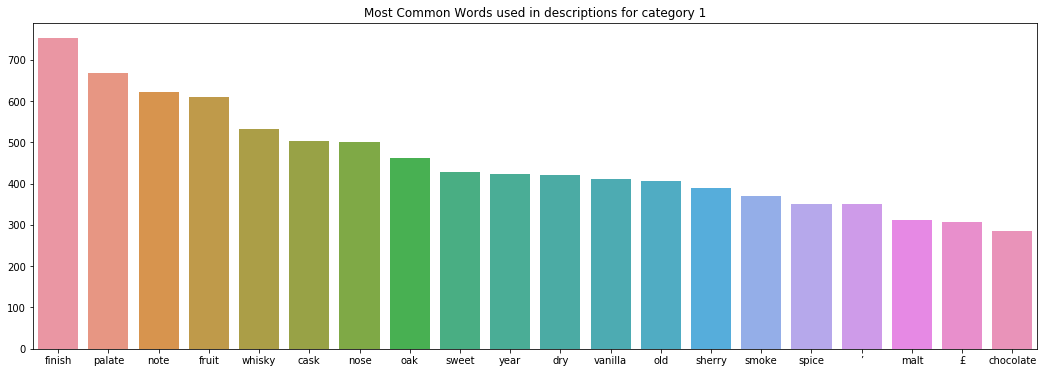

In [7]:
one_common_words = [word[0] for word in one_counts.most_common(20)]
one_common_counts = [word[1] for word in one_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=one_common_words, y=one_common_counts)
plt.title('Most Common Words used in descriptions for category 1')
plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
import spacy
spacy.load('en_core_web_lg')
from spacy.lang.en import English
parser = English()

In [9]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text
def tokenizeText(sample):
    tokens = parser(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

In [10]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
vectorizer = CountVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf = LinearSVC()

pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
# data
train1 = train_two['description'].tolist()
labelsTrain1 = train_two['category'].tolist()
test1 = val['description'].tolist()
labelsTest1 = val['category'].tolist()
# train
pipe.fit(train1, labelsTrain1)
# test
preds = pipe.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print("Top 10 features used to predict: ")

printNMostInformative(vectorizer, clf, 10)
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = pipe.fit_transform(train1, labelsTrain1)
vocab = vectorizer.get_feature_names()
for i in range(len(train1)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

accuracy: 0.9425427872860636
Top 10 features used to predict: 
Class 1 best: 
(-0.7255958314750771, 'whiskey')
(-0.47020327783403887, 'hot')
(-0.46982354499154305, 'corn')
(-0.45929052319053787, 'canadian')
(-0.3765161436896087, 'bourbon')
(-0.37472606969562133, 'rye')
(-0.3521699900114298, 'candied')
(-0.3106312379945855, 'caramel')
(-0.3002391745519678, 'canada')
(-0.26197301169465476, 'tobacco')
Class 2 best: 
(0.5227261366533971, '£')
(0.3322601099482667, 'foundation')
(0.3277443540281032, 'cask')
(0.3038600980594028, 'uncomplicated')
(0.2770606670690702, 'emerge')
(0.25729988857306035, 'lengthy')
(0.2557107982566517, 'dram')
(0.2508324000886666, '10')
(0.24378201644506803, 'briny')
(0.23634080672002492, 'grape')


In [11]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])
pred = pipe.predict(test['description'])
submission = pd.DataFrame({'id': test['id'], 'category': pred})
submission['category'] = submission['category'].astype('int64')
submission.head()
submission.to_csv('ds4-which-whisk/submission7.csv', index=False)